# QPE and QPF

&nbsp;

## Contents

&nbsp;

. [Quantum Period Finding](#qpf)

&nbsp;

**Module Imports**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# importing Qiskit
from qiskit import Aer, IBMQ
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import execute, transpile

from qiskit.tools.visualization import plot_histogram

#IBMQ.load_account()

import math
from math import pi

In [2]:
# Plot results
def show_results(D):
    # D is a dictionary with classical bits as keys and count as value
    # example: D = {'000': 497, '001': 527}
    plt.bar(range(len(D)), list(D.values()), align='center')
    plt.xticks(range(len(D)), list(D.keys()))
    plt.show()

# Execute circuit, display a histogram of the results
def execute_locally(qc, draw_circuit=False):
    # Compile and run the Quantum circuit on a simulator backend
    backend_sim = Aer.get_backend('qasm_simulator')
    job_sim = execute(qc, backend_sim)
    result_sim = job_sim.result()
    result_counts = result_sim.get_counts(qc)
    
    # Print the results
    print("simulation: \n\n", result_counts)
    show_results(result_counts)
    return result_counts


&nbsp;

## 1. Quantum period finding <a id='qpf'></a>

&nbsp;

Admit a function $f(x)$ from $n$-bit numbers to $m$-bit numbers. Consider $f(x)$ periodic of period $r$, meaning that $\forall x \in \{0,\cdots,N-r-1\}$, we have that $f(x) = f(x+r)$ and the values $f(x), f(x+1), \cdots, f(x+r-1)$ are all distinct. Suppose also that $ r \leq \sqrt{N}/2$


In a quantum algorithm, this function translates to an $n$-qubit input register and an $m$-qubit output register. We can prepare in the state:

$$ | \psi_0 \rangle = \frac{1}{\sqrt{N}} \sum_{x=0}^{2^n-1} | x\rangle |0\rangle$$

Using $n$ Hadamard gates.

We then apply a circuit that performs the unitary $\hat{U}_f$:

$$\hat{U}_f | \psi_0 \rangle =\frac{1}{\sqrt{N}} \sum_{x=0}^{2^n-1} | x\rangle | f(x) \rangle$$

If we measure the output register _only_ , we get a particular value $a$. The input register will be left in an evenly-weighted superposition of all $x$ such that $f(x) = a$:

$$\frac{1}{\sqrt{N/r}} \sum_{n=0}^{N/r-1} |x_0 + nr \rangle | a \rangle$$

From now on, we will ignore the output register since the measurement has fixed its state.

If we apply the QFT to the input register, we will gate a state in the form:

$$\sum_{m=0}^{r-1} \alpha_m |m N/r\rangle$$

If we now measure the input register, we would get one value $mN/r$, for some random $m$ between $0$ and $r-1$.

* This is not enough to tell us the value of $N/r$, but if we run the algorithm $d$ times, we will get a sequence of integers $m_1 N/r, \cdots, m_d N/r$ which are all multiples of $N/r$.


<div class="alert alert-block alert-warning">

**Exercise 1**

&nbsp;

Using the period finding technique detailed above, find the period of the function $f:\{0,1\}^3 \rightarrow \{0,1\}^3$ below.

&nbsp;

Notes:

* For a sufficiently large number of runs $d$ (which grows moderately in $N$) we can be confident that, with high probability, $N/r$ is the only common factor of all the numbers.


</div>

In [5]:
def qftransform(circuit, qr, swap=True): 
    N=len(qr)
    for i in range(N):
        circuit.h(qr[N-i-1])
        for j in range(i+1,N):
            circuit.cp(2*pi/2**(j-i+1),qr[N-j-1],qr[N-i-1])
        circuit.barrier()
    if swap==True:
        for i in range(N//2):
            circuit.swap(qr[N-i-1], qr[i])

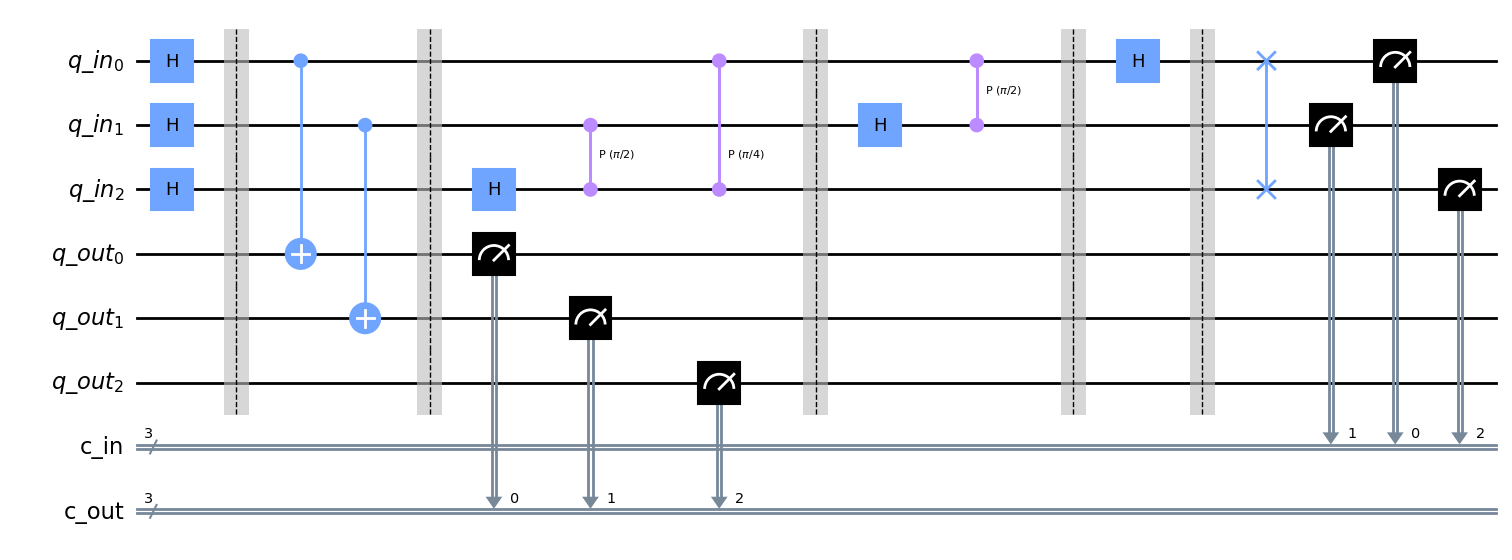

In [6]:
qin = QuantumRegister(3, 'q_in')
qout = QuantumRegister(3, 'q_out')
cin = ClassicalRegister(3, 'c_in')
cout = ClassicalRegister(3, 'c_out')
qc = QuantumCircuit(qin, qout, cin, cout)

qc.h(qin)

qc.barrier()

#Uf
qc.cx(qin[0],qout[0])
qc.cx(qin[1],qout[1])

qc.barrier()

qc.measure(qout,cout)

qftransform(qc, qin)

qc.measure(qin,cin)


qc.draw(output='mpl')

In [7]:
from math import gcd
from functools import reduce

#Simulate
simulator = Aer.get_backend('qasm_simulator')
job = execute(qc, simulator, shots=10)
result = job.result()
counts = result.get_counts(qc)

# convert to numbers
k=[]
for i in counts.keys():
    k.append(int(i[4:7],2))

# get the maximum common divisor
x = reduce(gcd, k)

# period:
n=qin.__len__()
r=int(2**n/x)
print("the period is: "+str(r)+".")

the period is: 4.
